In [1]:
import joblib

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

# Outline
0. [EDA](#eda)
1. [Missing Value Imputation](#mvalimp)
2. [Recommender System](#recosys)
3. [Model Training](#train)
4. [System Design](#sysdes)
5. [POC Deployment](#dep)

In [2]:
X = pd.read_csv("../data/recipeData.csv", encoding='iso-8859-1')
y = pd.read_csv("../data/styleData.csv", encoding='iso-8859-1')
X.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,...,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,...,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,...,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


## (0) Short EDA <a class="anchor" id="eda"></a>
Some quick notes:
- Missing styles have StyleID 111, which is a catch all id for missing `Style`s (as opposed to one specific style always missing)
- Since we don't have labels for the missing values, we can't recover the distribution of missing values over `Style`s. However, we can still use the class priors from the training set as a baseline, assuming that the priors are the same for rows with missing values (which may be an incorrect assumption).
- Imbalanced classes (Largest: American IPA, baseline to try: constant prediction)

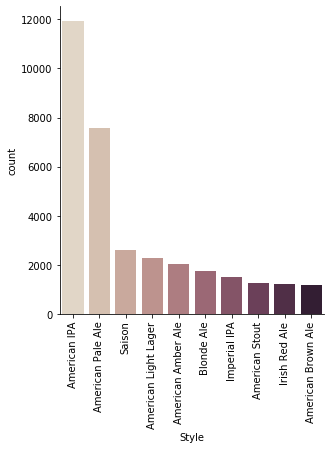

In [3]:
g = sns.catplot(x="Style", kind="count", palette="ch:.25", data=X,
               order=X["Style"].value_counts().iloc[:10].index)
g.set_xticklabels(rotation=90)

In [4]:
X[X['Style'].isna()].head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
38,39,Rochefort 8 Clone,/homebrew/recipe/view/188995/rochefort-8-clone,NaN,111,18.93,1.079,1.019,7.90,0.00,...,NaN,65.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
87,88,Zatarain's Root Beer - Non-Alcoholic keg in...,/homebrew/recipe/view/21783/zatarain-s-root-be...,NaN,111,18.93,1.046,1.013,4.27,0.00,...,1.077,100.0,NaN,Specific Gravity,BIAB,NaN,NaN,NaN,NaN,993.0
192,193,Hop Cliff,/homebrew/recipe/view/188896/hop-cliff,NaN,111,18.93,1.093,1.023,9.12,0.00,...,NaN,75.0,NaN,Specific Gravity,Partial Mash,NaN,NaN,NaN,NaN,NaN
347,348,Mosaic IPL,/homebrew/recipe/view/56751/mosaic-ipl,NaN,111,20.82,1.063,1.016,6.16,68.35,...,NaN,78.0,NaN,Specific Gravity,All Grain,2.0,10.0,NaN,NaN,15452.0
577,578,Nanny state,/homebrew/recipe/view/329814/nanny-state,NaN,111,20.00,1.008,1.006,0.30,55.43,...,1.006,70.0,3.0,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,3053.0


In [5]:
y[y['Style'].isna()]

,Style,StyleID
110,NaN,111


## (1) Missing Value Imputation <a class="anchor" id="mvalimp"></a>
Once you've decided not to delete columns or rows to remove missing values, you have to come up with a way to impute them. In this case missing values should not be missing completely at random. That is, the probability of a value being missing is either not independent of other features or the distribution of missing values is not uniform.
1. Mean/Median/Mode: The simplest method involves replacing missing values with the mean/mode/median of that column. The mode is typically used for categorical features and the mean or median for numerics (the median may be better if you have outliers that you have chosen not to drop/clip).
2. Stratification: You can also cluster your data based on other features (either with an ad hoc procedure or a clustering algorithm) and fill in missing values based on the mean/median/mode of a cluster
3. KNN: Predict missing values based on nearest neighbors
4. Prediction: Train a classifier or regressor on rows w/o missing data

(1) should work best if there is a weak relationship between missing values and other features, otherwise (3) or (4) should work better.

## (2) Recommender System <a class="anchor" id="recosys"></a>
One approach would be to use item-based collaborative filtering, where we define a distance metric between recipes and recommend recipes to users that have a minimum distance to their previously submitted recipes. One way to define the distance metric is the sum of distances between features, using euclidean distance for numeric features and hamming distance for categorical ones.

## (3) Train a Model to solve (1) <a class="anchor" id="train"></a>


In [6]:
X.isna().sum() / (X.count() + X.isna().sum())

BeerID           0.000000
Name             0.000014
URL              0.000000
Style            0.008069
StyleID          0.000000
Size(L)          0.000000
OG               0.000000
FG               0.000000
ABV              0.000000
IBU              0.000000
Color            0.000000
BoilSize         0.000000
BoilTime         0.000000
BoilGravity      0.040481
Efficiency       0.000000
MashThickness    0.404327
SugarScale       0.000000
BrewMethod       0.000000
PitchRate        0.531431
PrimaryTemp      0.306820
PrimingMethod    0.908395
PrimingAmount    0.935365
UserId           0.683581
dtype: float64

### Feature Selection
Due to time constraints, we will just build a baseline classifier, dropping Ids, text fields, and non-standardized fields (viz. 'PrimingMethod' and 'PrimingAmount'), as well as features with nulls. We will assume that fields without nulls are enforced to not have nulls by the form that clients submit and will respond with a message declaring an invalid input if they are null in test/production.

In [7]:
to_drop = ['BeerID', 'PrimingMethod', 'PrimingAmount', 'URL', 'UserId', 'Name']
has_null = ['MashThickness', 'BoilGravity', 'PitchRate', 'PrimaryTemp']
X.drop(labels=to_drop+has_null, axis=1, inplace=True)
X.head()

,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,Efficiency,SugarScale,BrewMethod
0,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,70.0,Specific Gravity,All Grain
1,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,70.0,Specific Gravity,All Grain
2,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60,70.0,Specific Gravity,extract
3,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,26.50,60,70.0,Specific Gravity,All Grain
4,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,60.00,90,72.0,Specific Gravity,All Grain


#### Convert Categoricals
We will one-hot encode `SugarScale` and `BrewMethod` because they have a small number of levels and have no natural ordering.

In [8]:
X = pd.get_dummies(X, columns=['SugarScale','BrewMethod'])

#### Split train & test

In [9]:
train = X[X['Style'].notna()]
# rows with missing style are useless for training and eval
# with_null_style = X[X['Style'].isna()]
x_train = train.drop(['Style', 'StyleID'], axis=1)
y_train = train['StyleID']
# we'll use k-fold cv in GridSearch and test on x_test, y_test
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=7)

### Baseline Dummy Classifiers

In [10]:
strat = DummyClassifier(strategy="stratified")
mf = DummyClassifier(strategy="most_frequent")
uni = DummyClassifier(strategy="uniform")
for name, clf in [("stratified", strat), ("most_frequent", mf), ("uniform", uni)]:
    clf.fit(x_train, y_train)
    print(f"{name}: {clf.score(x_train,y_train)}, {clf.score(x_test,y_test)}")

stratified: 0.045570357428841815, 0.04323852159196375
most_frequent: 0.1638276188396302, 0.1603974449964514
uniform: 0.005641697605008372, 0.006442102964459246


### RandomForest

In [11]:
rf = RandomForestClassifier(random_state=7, n_jobs=-1)
# param grids are reduced from previous hparam searches
# this model is quite large with 500 estimators and may need to be shrunk
# depending on memory constraints we may want to impose
params = {'n_estimators': [500],
         'min_samples_split': [10]}
best_rf = GridSearchCV(rf, param_grid=params, scoring=['f1_micro', 'accuracy'], refit='f1_micro')
best_rf.fit(x_train, y_train)
best_rf.score(x_train, y_train), best_rf.score(x_test, y_test), best_rf.best_params_

/home/alec/proj/takehomes/pager/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/alec/proj/takehomes/pager/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


(0.8364999636019509,
 0.35759130862040733,
 {'min_samples_split': 10, 'n_estimators': 500})

 #### Random Forest Classifier Results
 (Train F1 micro, Test F1 micro, Params)
 
(0.8364999636019509,
 0.3575913086204073,
 {'min_samples_split': 10, 'n_estimators': 500})

### KNN

In [12]:
knn = KNeighborsClassifier(n_jobs=-1)
# param grids are reduced from previous hparam searches
params = {'n_neighbors': [50]}
best_knn = GridSearchCV(knn, param_grid=params, scoring=['f1_micro', 'accuracy'], refit='f1_micro')

# Subtract mean and divide by stddev for knn, since it is sensitive to feat scales
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

best_knn.fit(x_train_scaled, y_train)
best_knn.score(x_train_scaled, y_train), best_knn.score(scaler.transform(x_test), y_test), best_knn.best_params_

/home/alec/proj/takehomes/pager/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/alec/proj/takehomes/pager/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


(0.3411407148576836, 0.31189605284708194, {'n_neighbors': 50})

#### KNN Results
Standard scaled Feats:
(0.3411407148576836, 0.31189605284708194, {'n_neighbors': 50})

Unscaled feats:
(0.3070539419087137, 0.2755363869629306, {'n_neighbors': 50})

### Ensemble of previous models
Quick check to see if previous models performed well on different subsets of the dataset. Performance decreased, so I left the code block out.

### Recap & Further Iteration
I suspect that utilizing the `Name` field will be the largest improvement to be made in this model. A simple approach would be to just use tfidf scores as features, perhaps with lemmatization & stemming. Another method with a similar justification would be to extract sentence vectors for the `Name` field as well as the `Style` field and train a small classifier to predict the `Style` sentence vector given the `Name` sentence vector.

It may also be helpful to look more into unstructured fields like `PrimingAmount` and try to extract categorical variables from common values.

The random forest model is also massively overfitting, so trying to regularize that model more would be worthwhile. Simple methods such as reducing number of estimators and capping the max depth of trees decrease test accuracy.

## (4) System Design <a class="anchor" id="sysdes"></a>
Possible Approaches:
1. Direct Integration into Client Application
2. Message queue integration
3. Web Service API

Direct Integration into the Client Application requires sending, storing and running the model on the client side, where resources and compute may be sparse. Although our the knn model is relatively small, the rf model can be multiple GB with ~500 estimators. I've only used this type of deployment for data privacy reasons, which does not apply here.

Message queue integration is best for services that can be run asynchronously and only require near-real-time prediction.

Because our model does not perform extraordinarily well, it may be best used to serve suggestions to the user from which they can select the correct `Style`, to avoid inserting incorrect data into the db.

Therefore the Pub/sub integration simplifies the sequence flow and allows model predictions to be performed in the background, but the webservice api may reduce the impact of bad predictions by allowing a human-in-the-loop.

I will implement the Webservice api here as a Proof-of-concept and because I have no access to a message queue. The service will accept requests that contain values for all `features` defined below and will respond with a defined value for `prediction`. 

### Serialize best model

In [15]:
with open("../assets/rf_model.pk", "wb") as model_file:
    joblib.dump(best_rf, model_file)

### Serialize feature list

In [14]:
features = [feat for feat in x_train.columns if feat not in set(has_null+to_drop)]
with open("../assets/feat_list.pk", "wb") as feat_list_file:
    joblib.dump(features, feat_list_file)
features

['Size(L)',
 'OG',
 'FG',
 'ABV',
 'IBU',
 'Color',
 'BoilSize',
 'BoilTime',
 'Efficiency',
 'SugarScale_Plato',
 'SugarScale_Specific Gravity',
 'BrewMethod_All Grain',
 'BrewMethod_BIAB',
 'BrewMethod_Partial Mash',
 'BrewMethod_extract']

## (5) API <a class="anchor" id="dep"></a>
The api is defined as a flask application in `src/api.py`. Tests of the api can be run from `test/test_api.py`.